In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

def cosinus_signal_func(freq = None, T = None, init_phase = 0):
    if freq:
        w = 2 * np.pi * freq
    elif T:
        w = 2 * np.pi / T
    else:
        return None
    cos_func = lambda t: np.cos(t * w + init_phase)

    return cos_func

def rec_imp(t):
    t_r = np.floor(t)
    if t_r % 2 == 0:
        return 2
    else:
        return -2

def calc_signal(s_func, t_start = 0, t_end = None, steps_cnt = None, noised=False):
    if t_end is None:
        t_end = 2
    if steps_cnt is None:
        steps_cnt = 250

    time_series = np.linspace(t_start, t_end, steps_cnt)
    signal_vals = np.array([s_func(t) for t in time_series])
    if noised: signal_vals += np.random.normal(0, 1, signal_vals.shape)

    return signal_vals, time_series

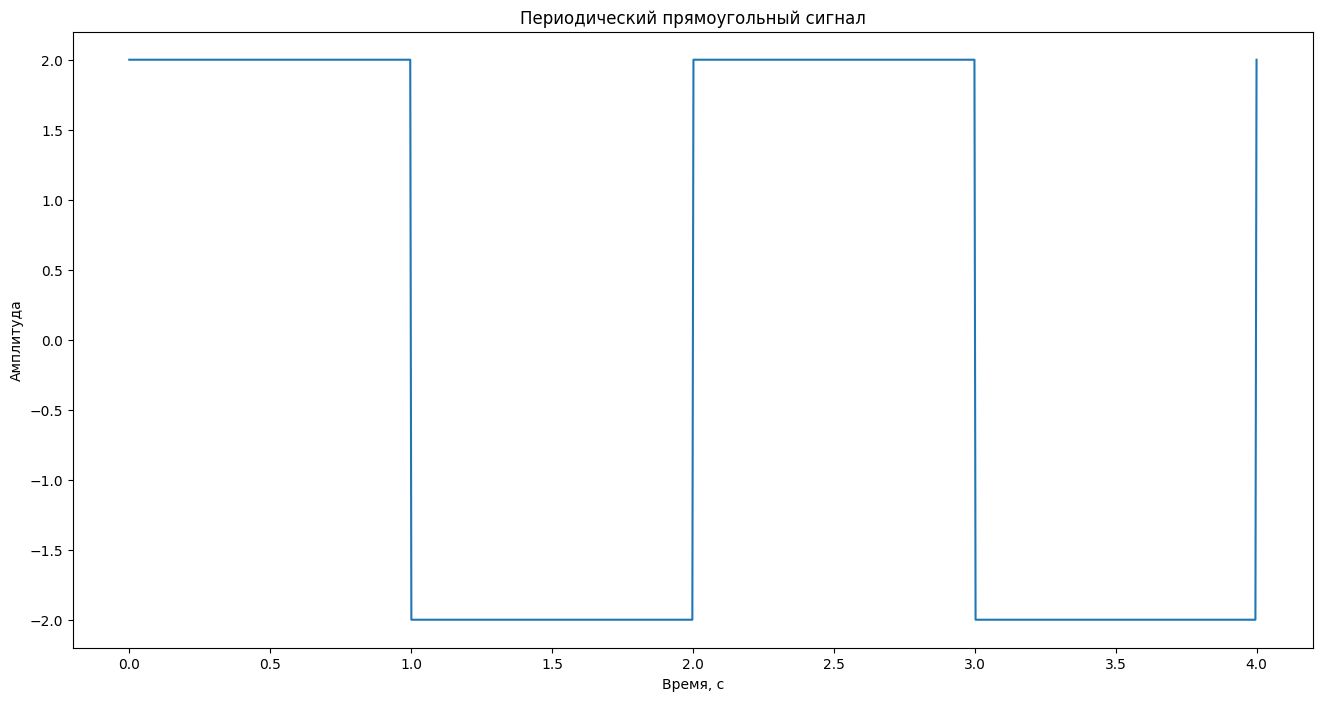

In [111]:
square_signal, square_time_series = calc_signal(rec_imp, t_end=4, steps_cnt=1000)

fig = plt.figure(figsize=(16,8))

plt.title("Периодический прямоугольный сигнал")
plt.ylabel("Амплитуда")
plt.xlabel("Время, с")
plt.plot(square_time_series, square_signal)
plt.show()

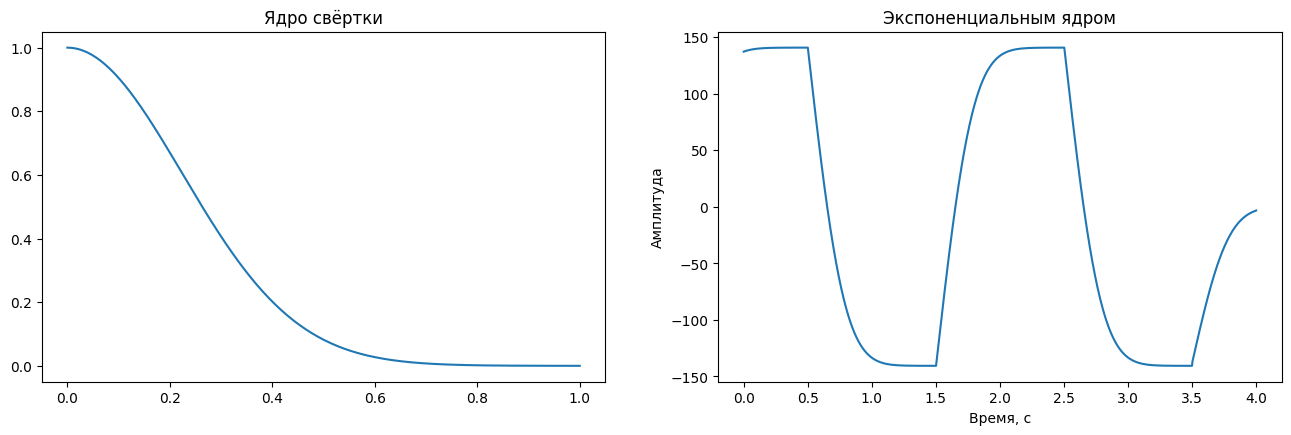

In [112]:
def kernel_exp(x, A):
    return A*np.exp(-np.power(x, 2)/0.1)

kernel_xs = np.linspace(0, 1, 250)
kernel_expo_vals = kernel_exp(kernel_xs, 1)

fig = plt.figure(figsize=(16,10))

plt.subplot(221)
plt.title("Ядро свёртки")
plt.plot(kernel_xs, kernel_expo_vals)

square_conved = np.convolve(square_signal, kernel_expo_vals, 'same')

plt.subplot(222)
plt.title("Экспоненциальным ядром")
plt.ylabel("Амплитуда")
plt.xlabel("Время, с")
plt.plot(square_time_series, square_conved)

plt.show()

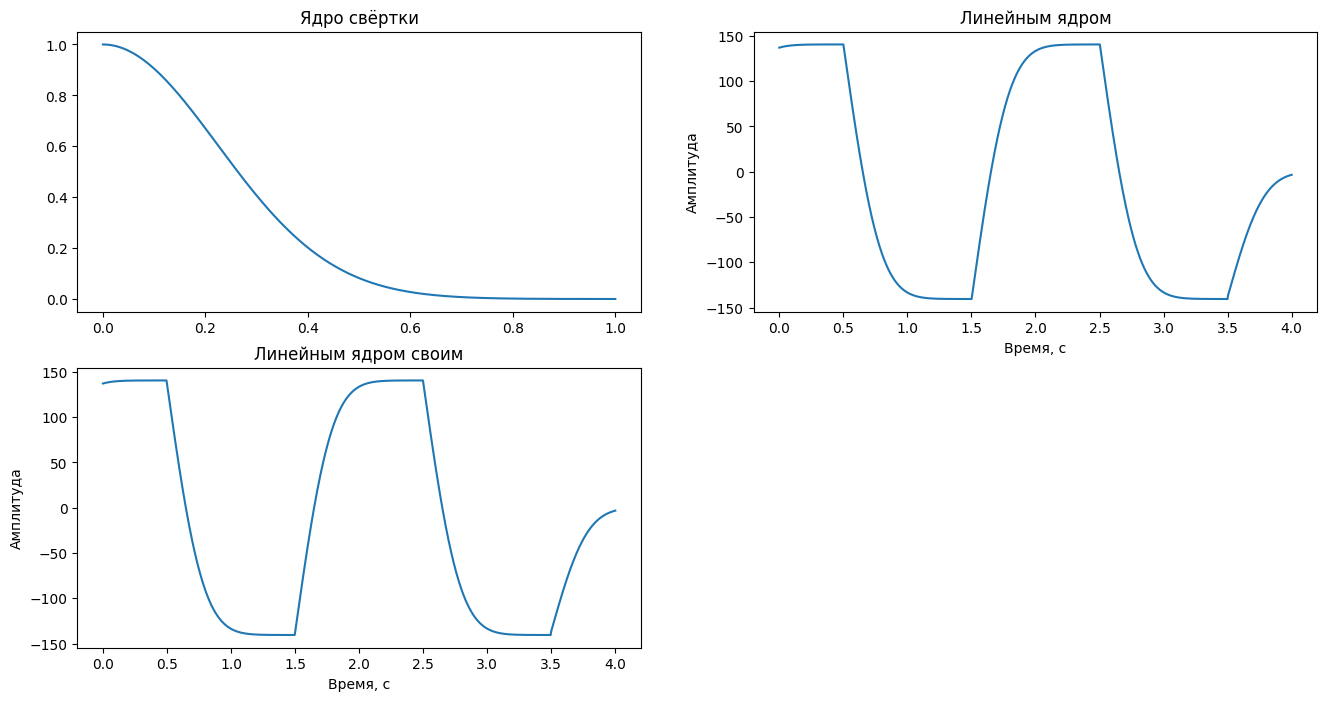

0.004

In [113]:
def kernel_linear(a, x, b):
    return a * x + b

kernel_xs = np.linspace(0, 1, 250)
kernel_linear_vals = kernel_linear(1, kernel_xs, 5)
# kernel_xs = np.linspace(0, 1, 250)
kernel_expo_vals = kernel_exp(kernel_xs, 1)

square_conved = np.convolve(square_signal, kernel_expo_vals, 'same')




def conv(signal, filter_kernel):
    # Определяем длины сигнала и ядра
    signal_length = len(signal)
    kernel_length = len(filter_kernel)

    # Дополняем сигнал и ядро нулями до нужной длины
    padded_signal = np.pad(signal, (0, kernel_length - 1), 'constant')
    padded_kernel = np.pad(filter_kernel, (0, signal_length - 1), 'constant')

    # Применяем преобразование Фурье к сигналу и ядру свертки
    signal_fft = np.fft.fft(padded_signal)
    kernel_fft = np.fft.fft(padded_kernel)

    # Выполняем поэлементное умножение в частотной области
    result_fft = signal_fft * kernel_fft

    # Применяем обратное преобразование Фурье и коррекцию амплитуд
    result = np.fft.ifft(result_fft)

    # Сдвигаем результат, чтобы учесть разницу в нулевых значениях
    result = np.roll(result, -kernel_length // 2)[:signal_length]

    return np.real(result)

fig = plt.figure(figsize=(16,8))

plt.subplot(221)
plt.title("Ядро свёртки")
plt.plot(kernel_xs, kernel_expo_vals)

plt.subplot(222)
plt.title("Линейным ядром")
plt.ylabel("Амплитуда")
plt.xlabel("Время, с")
plt.plot(square_time_series, square_conved)

square_conved = conv(square_signal, kernel_expo_vals)
plt.subplot(223)
plt.title("Линейным ядром своим")
plt.ylabel("Амплитуда")
plt.xlabel("Время, с")
plt.plot(square_time_series, square_conved)

plt.show()
np.mean(square_signal)

In [114]:
def extend_arr(arr, axis_0_len):
    l = list(arr)
    l_orig = l.copy()
    while len(l) < axis_0_len:
        l += l_orig
    return np.array(l)[:axis_0_len]

def fft_full(xs, ys, normalize=False):
    spectrum = np.fft.fft(ys)
    if normalize: normalize(spectrum)
    freq_series = np.fft.fftfreq(len(xs), 1/len(xs))
    return [freq_series, (spectrum)]

def normalize(arr, id=None):
    if id is None and len(arr) > 6: return arr/np.max(arr)

    arr[id] = arr[id]/np.max(arr[id])
    return arr

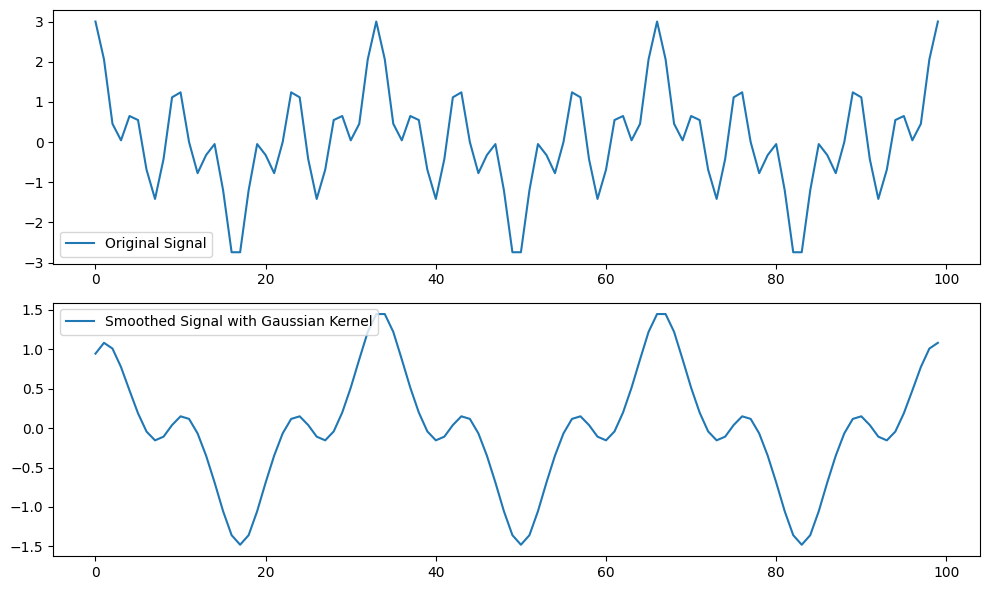

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

def gaussian_kernel(size, sigma=1):
    """Генерация ядра Гаусса"""
    kernel = np.fromfunction(
        lambda x: (1/ (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x - (size - 1) / 2) ** 2 / (2 * sigma ** 2)),
        (size,)
    )
    return kernel / np.sum(kernel)

def gaussian_smooth(signal, kernel_size=3, sigma=1):
    """Сглаживание сигнала с использованием свертки с ядром Гаусса"""
    kernel = gaussian_kernel(kernel_size, sigma)
    smoothed_signal = convolve(signal, kernel, mode='same', method='direct')
    return smoothed_signal

# Пример использования
if __name__ == "__main__":
    # Создаем пример сигнала
    signal_length = 100
    cos_50f = cosinus_signal_func(50)
    cos_150f = cosinus_signal_func(150)
    cos_250f = cosinus_signal_func(350)
    cos_sum = lambda t: cos_50f(t) + cos_150f(t) + cos_250f(t)
    cos_sum_vals, cos_sum_time = calc_signal(cos_sum, t_end=6, steps_cnt=100)

    # Задаем параметры ядра Гаусса
    kernel_size = 100
    sigma = 2

    # Выполняем сглаживание сигнала
    smoothed_signal = gaussian_smooth(cos_sum_vals, kernel_size, sigma)

    # Визуализируем результаты
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(cos_sum_vals, label='Original Signal')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(smoothed_signal, label='Smoothed Signal with Gaussian Kernel')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [120]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_frequency_kernel(size, sigma=1):
    """Генерация ядра Гаусса в частотной области"""
    rows = np.fft.fftfreq(size[0])
    cols = np.fft.fftfreq(size[1])
    
    x, y = np.meshgrid(rows, cols)
    kernel = np.exp(-2 * np.pi**2 * sigma**2 * (x**2 + y**2))
    
    return kernel / np.sum(kernel)

def gaussian_frequency_filter(signal, kernel_size=3, sigma=1):
    """Фильтрация сигнала с использованием фильтра Гаусса в частотной области"""
    signal_fft = np.fft.fft2(signal)
    kernel = gaussian_frequency_kernel(signal.shape, sigma)
    
    result_fft = signal_fft * kernel
    result = np.fft.ifft2(result_fft)
    
    return np.real(result)

# Пример использования
if __name__ == "__main__":
    # Создаем пример сигнала
    signal_length = 100
    signal = np.sin(2 * np.pi * 5 * np.arange(signal_length) / signal_length)  # Пример синусоиды

    # Задаем параметры фильтра Гаусса в частотной области
    kernel_size = signal_length
    sigma_narrow = 0.1  # для узкополосного фильтра
    sigma_lowpass = 5.0  # для фильтра нижних частот

    # Применяем фильтры
    filtered_signal_narrow = gaussian_frequency_filter(signal, kernel_size, sigma_narrow)
    filtered_signal_lowpass = gaussian_frequency_filter(signal, kernel_size, sigma_lowpass)

    # Визуализируем результаты
    plt.figure(figsize=(12, 8))
    
    plt.subplot(3, 1, 1)
    plt.plot(signal, label='Original Signal')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(filtered_signal_narrow, label='Filtered Signal (Narrow Filter)')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(filtered_signal_lowpass, label='Filtered Signal (Lowpass Filter)')
    plt.legend()

    plt.tight_layout()
    plt.show()


IndexError: index -2 is out of bounds for axis 0 with size 1